In [1]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A

In [2]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
!pip3 install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1279 sha256=23033bba9426c5c321613349928214c21706586030a7a805a023c6f7c40dc341
  Stored in directory: /root/.cache/pip/wheels/80/dc/7a/f8af45bc239e7933509183f038ea8d46f3610aab82b35369f4
Successfully built unzip


In [ ]:
!unzip /content/drive/MyDrive/Colab/full_labels_for_deep_learning/masks_as_128x128_patches.zip
!mkdir mask
!cp -r  *.png ./mask/
!rm *.png 

!unzip /content/drive/MyDrive/Colab/full_labels_for_deep_learning/images_as_128x128_patches.zip
!mkdir image
!cp -r  *.png ./image/
!rm *.png 

In [29]:
def to_categorical(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with `categorical_crossentropy`.
    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
          as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.
    Returns:
        A binary matrix representation of the input as a NumPy array. The class
        axis is placed last.
    Example:
    >>> a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
    >>> print(a)
    [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]
    >>> b = tf.constant([.9, .04, .03, .03,
    ...                  .3, .45, .15, .13,
    ...                  .04, .01, .94, .05,
    ...                  .12, .21, .5, .17],
    ...                 shape=[4, 4])
    >>> loss = tf.keras.backend.categorical_crossentropy(a, b)
    >>> print(np.around(loss, 5))
    [0.10536 0.82807 0.1011  1.77196]
    >>> loss = tf.keras.backend.categorical_crossentropy(a, a)
    >>> print(np.around(loss, 5))
    [0. 0. 0. 0.]
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [30]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import cv2
class McroscopingDataset(Dataset):
    
    def __init__(self,image_dir,mask_dir,transform=None):
      super().__init__()
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.transform = transform
      self.images = os.listdir(image_dir)
      

    def __len__(self):
      return len(self.images)

    def __getitem__(self,index):
          img_path = os.path.join(self.image_dir,self.images[index])
          mask_path = os.path.join(self.mask_dir,self.images[index]).replace('images_as','masks_as') 
          #mask_path = os.path.join(self.mask_dir,self.images[index])
          image = cv2.imread(img_path)
          mask = cv2.imread(mask_path,0)
          mask = mask - 1
          mask = to_categorical(mask, num_classes=4)
          if self.transform is not None:
              image = self.transform(image)
              mask = self.transform(mask)

              
          return image,mask

In [6]:
from torchvision import transforms
#train_images1 = train_images/255.
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])
#preprocess(train_images)

In [20]:
image = cv2.imread('/content/image/images_as_128x128_patches-0.png')
image.shape

(128, 128, 3)

In [31]:
image_dir = '/content/image'
mask_dir = '/content/mask'
data = McroscopingDataset(image_dir,mask_dir,preprocess)
image,mask= data.__getitem__(0)

In [32]:
mask.shape

torch.Size([4, 128, 128])

In [33]:
def get_images(image_dir,mask_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = McroscopingDataset(image_dir,mask_dir,transform = transform)
    #print(data)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch

In [34]:
image_dir = '/content/image'
mask_dir = '/content/mask'

In [35]:
train_batch,test_batch = get_images(image_dir,mask_dir,transform = preprocess,batch_size=8,shuffle=True,pin_memory=True)

torch.Size([8, 3, 128, 128])
torch.Size([8, 1, 128, 128])


TypeError: ignored

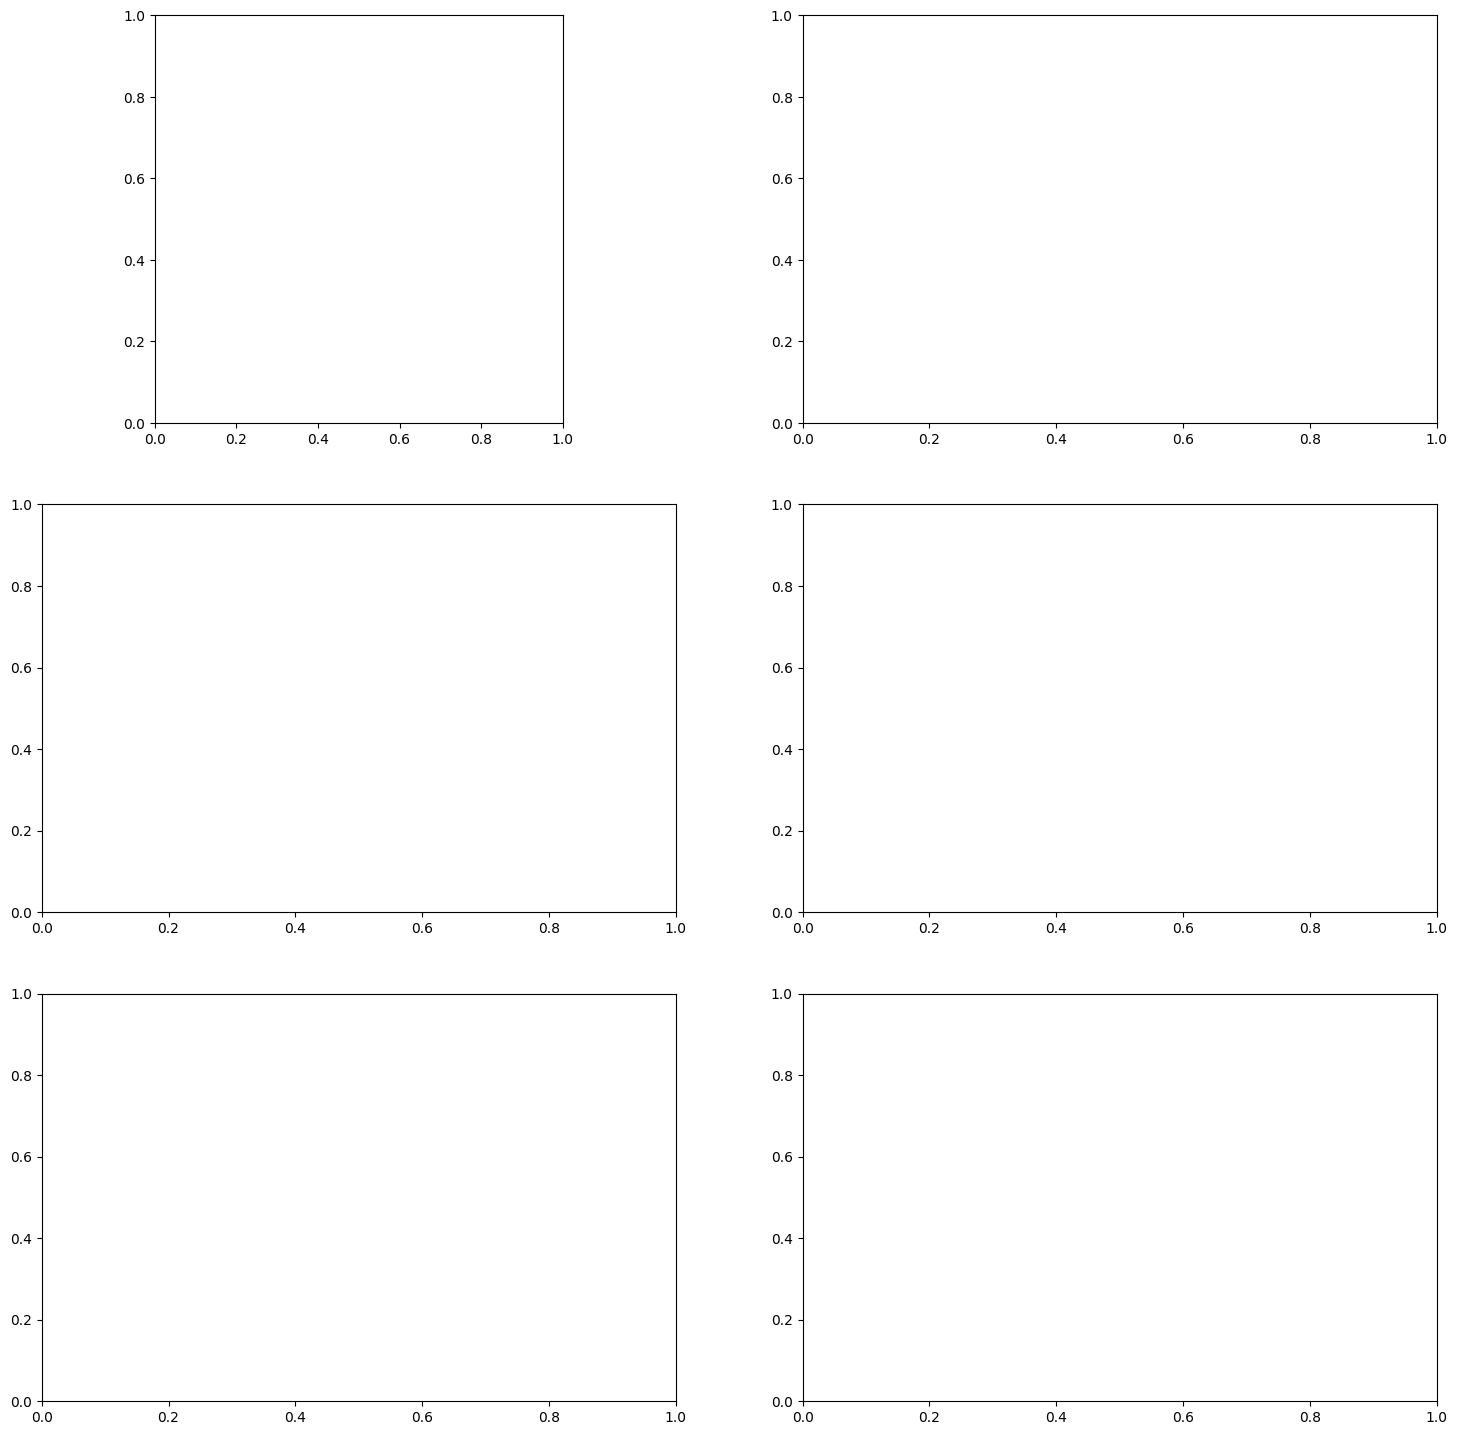

In [27]:
for img,mask in train_batch:
    print(img.shape)
    print(mask.shape)
    img1 = img[0,:,:,:]
    mask1 =mask[0,:,:]
    img2 = img[1,:,:,:]
    mask2 = mask[1,:,:]
    img3 = img[2,:,:,:]
    mask3 = mask[2,:,:]
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [11]:
!pip install torchsummary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)  

In [37]:
class unet_model(nn.Module):
    def __init__(self,out_channels=23,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [38]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
model = unet_model(out_channels=4).to(DEVICE)

In [47]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [88]:
LEARNING_RATE = 1e-4
num_epochs = 40

In [89]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [90]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        #targets = targets.type(torch.long)
        #print(data.shape)
        #print(targets.shape)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            #targets = targets.type(torch.long)
            #print("predictions:",predictions.shape)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

100%|██████████| 160/160 [00:12<00:00, 13.18it/s, loss=0.0062]


In [92]:
from torchmetrics import JaccardIndex

def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    meanIOU = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            #print(y)
            #return y
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            y = torch.argmax(softmax(y),axis=1)
            #print(preds.shape)
            #print(y.shape)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            jaccard = JaccardIndex(task='multiclass',num_classes=4).to(DEVICE)
            max = torch.max(y)
            IOU = jaccard(preds, y)
            meanIOU = meanIOU + IOU

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    print(f"Mean IOU: {meanIOU/len(loader)}")
    model.train()

In [66]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.9 MB/s eta 0:00:00


In [94]:
check_accuracy(train_batch, model)

Got 20922478/20971520 with acc 99.77
Dice score: 1.9987671375274658
Mean IOU: 0.9896486401557922


In [87]:
softmax = nn.Softmax(dim=1)
torch.argmax(softmax(y),axis=1).shape
#preds = torch.argmax(softmax(model(x)),axis=1)
#y = torch.argmax(softmax(y),axis=1)


torch.Size([8, 128, 128])

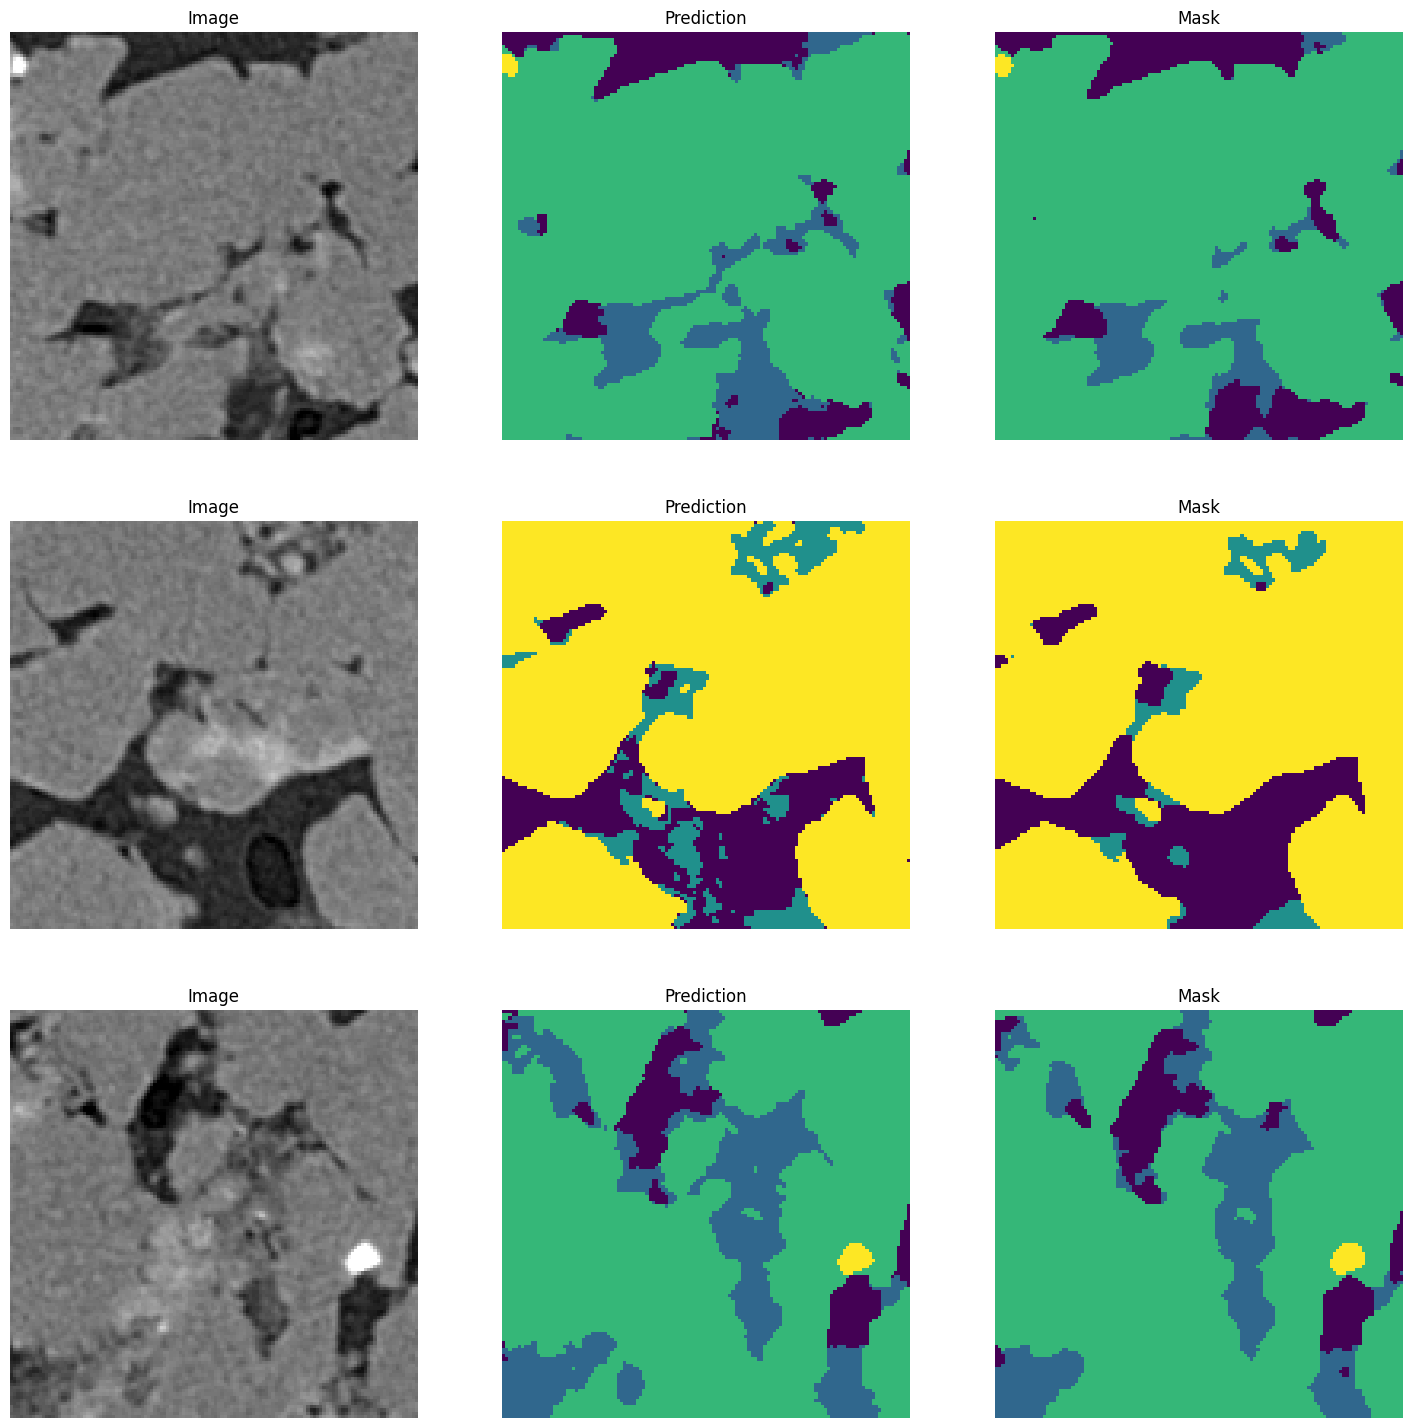

In [96]:
for x,y in train_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    y = torch.argmax(softmax(y),axis=1)
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break